#### Loading required libraries, data and visual inspection 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
data = pd.read_csv('stockdata.csv', )
print(data.shape)
data.head()

(98352, 8)


,day,timestr,a,b,c,d,e,f
0,1,09:30:00,325.450,13.795,94.500,49.985,49.93,17.025
1,1,09:31:00,325.245,13.890,94.515,49.990,49.96,17.025
2,1,09:32:00,325.580,13.905,94.565,49.995,49.96,17.025
3,1,09:33:00,325.470,13.955,94.645,50.065,49.92,17.025
4,1,09:34:00,325.295,13.975,94.580,50.030,49.90,17.025


In [3]:
data.describe()

,day,a,b,c,d,e,f
count,98352.00000,98281.000000,98352.000000,98321.000000,98334.000000,98352.000000,96981.000000
mean,181.29732,363.767737,10.048836,69.445570,49.803747,47.727738,13.204838
std,104.61705,28.281333,3.332643,28.675762,4.539923,7.053875,2.404705
min,1.00000,0.000000,4.885000,33.807000,1.000000,38.550000,9.365000
25%,89.00000,341.785000,6.605000,45.330000,46.175000,42.040000,10.945000
50%,180.00000,357.915000,10.595000,50.960000,50.105000,45.410000,13.325000
75%,271.00000,387.890000,13.465000,101.905000,53.735000,51.350000,15.035000
max,362.00000,426.560000,15.335000,116.385000,62.137000,69.210000,18.815000


#### Transforming timestrings to time in minutes
Notice that `timestr` is the only column in our data which is an object type (strings), not numerical. <br>
For simplicity of models, we'll convert those strings into integers by counting minutes. <br>
For example, the time `09:31:00` will be encoded as `60 * 9 + 31` minutes. 

In [4]:
def time_to_minutes(s):
    [a,b,c] = map(int, s.split(':'))
    return 60*a+b

data['timestr'] = data['timestr'].apply(time_to_minutes)
data = data.rename({'timestr':'time'},axis=1)

In [5]:
data.nunique()

day       252
time      391
a       18555
b        1380
c       12661
d        7141
e        2982
f         510
dtype: int64

#### Remarks
- Number of unique `time` is 391, which is different number of minutes from `09:30:00` to `16:00:00`, as expected. <br>
- Stock prices seem to have very different number of unique values, maybe some get traded at certain fixed values? <br> <br>
- Number of unique days is 252, which is the usual number of trading days in a year (read this online). <br>
Check visually if it looks like the usual 5 days of the week type numbers with weekends excluded.

In [6]:
day_list = sorted(set(data['day']))
print(day_list)

[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 16, 17, 18, 19, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 51, 52, 53, 54, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 100, 101, 102, 103, 106, 107, 108, 109, 113, 114, 115, 116, 117, 120, 121, 122, 123, 124, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 141, 142, 143, 144, 145, 149, 150, 151, 152, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 169, 170, 171, 172, 173, 176, 177, 178, 179, 180, 184, 185, 186, 187, 190, 191, 192, 193, 194, 197, 198, 199, 200, 201, 204, 205, 206, 207, 208, 211, 212, 213, 214, 215, 218, 219, 220, 221, 222, 225, 226, 227, 228, 229, 232, 233, 234, 235, 236, 239, 240, 241, 242, 243, 247, 248, 249, 250, 253, 254, 255, 256, 257, 260, 261, 262, 263, 264, 267, 268, 269, 270, 271, 274, 275, 276, 277, 278, 281, 282, 283, 284, 285, 288, 289, 290, 291, 292, 295, 296, 297, 298, 299, 302, 303, 304, 305, 306, 309, 

#### Check for missing values
If there aren't too many of them, we can look into simple imputer/data filling strategies

In [7]:
data.isna().sum()

day        0
time       0
a         71
b          0
c         31
d         18
e          0
f       1371
dtype: int64

#### Observations
- Among almost 100k data points, we have only few missing for most stocks. <br> 
`f` has largest number of values missing, but that's still around 0.1% only. <br>
- It makes sense to do a simple kind of imputer such as filling previously seen stock value <br>
(when there is no information, hopefully assuming the same price as 1 minute prior should not be a huge fluctuation)

#### Plot the prices to see any obvious errors in data

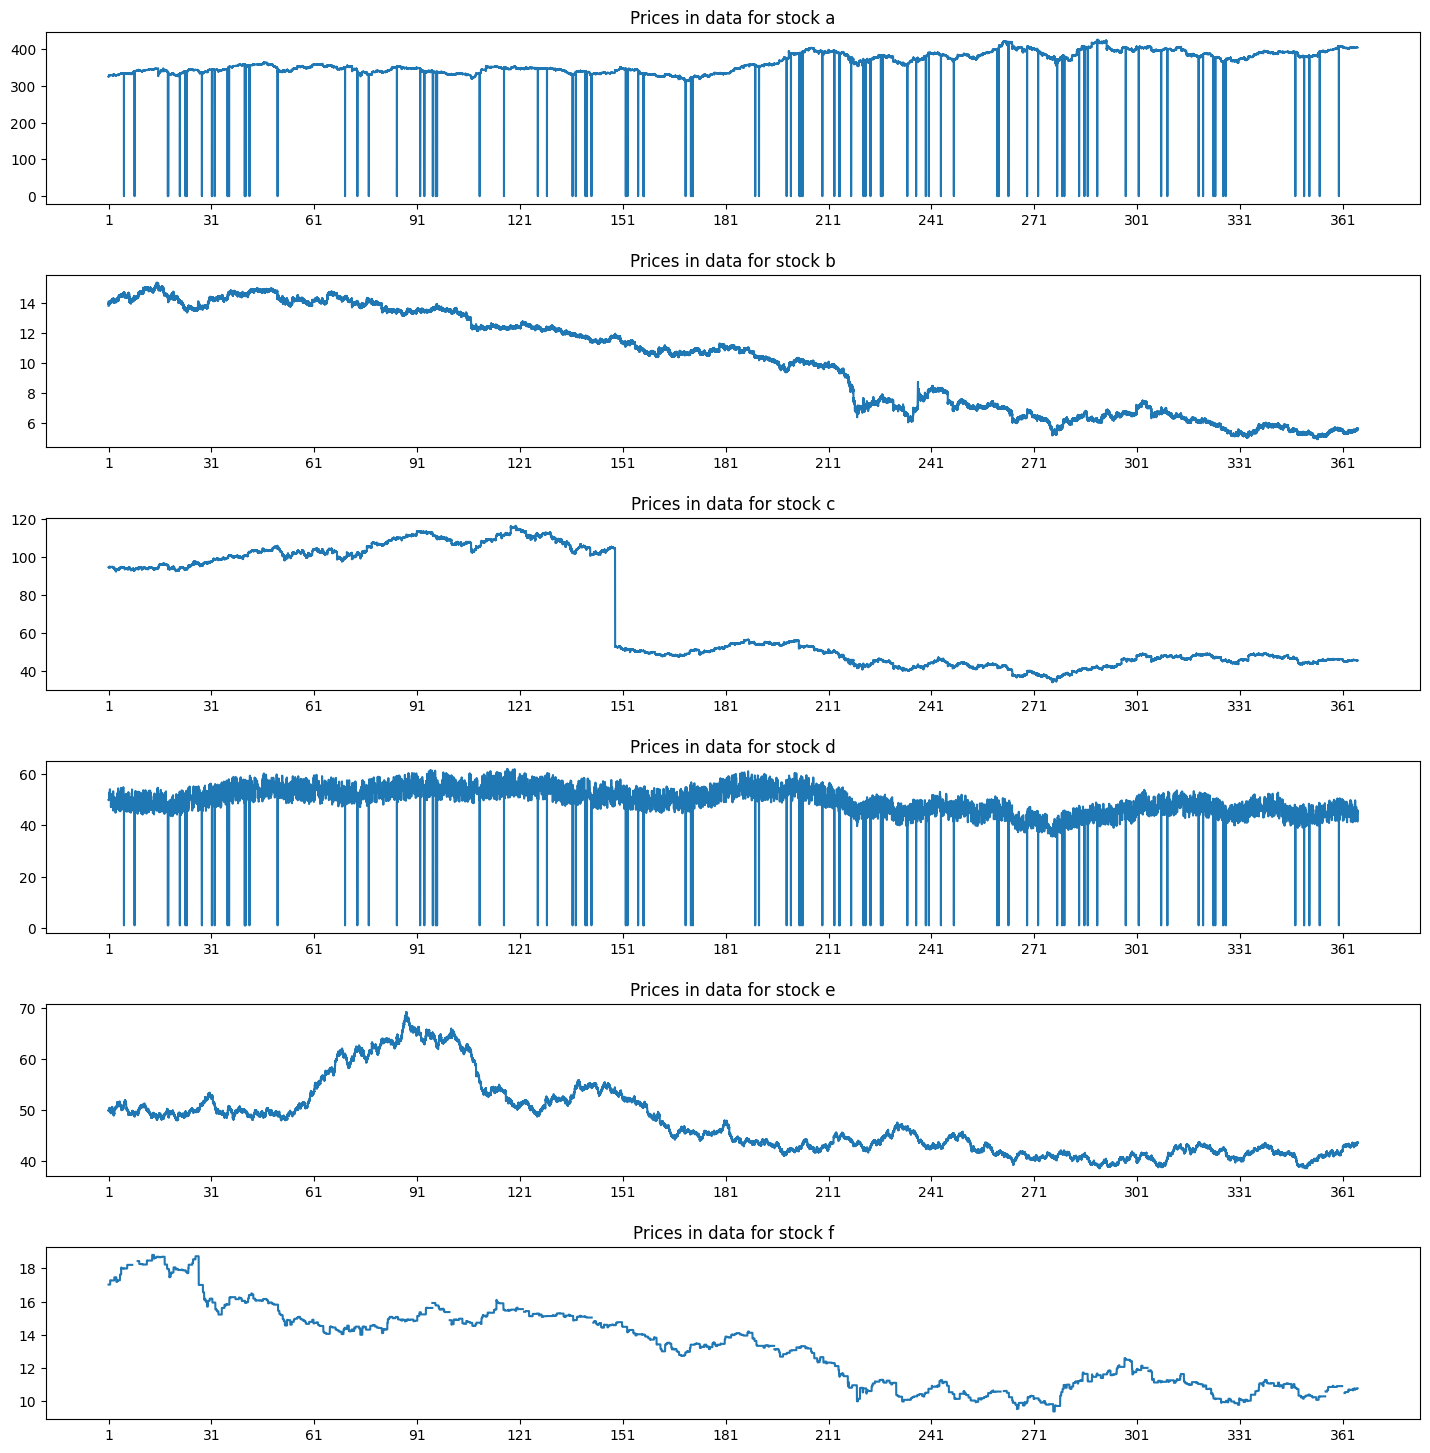

In [8]:
fig, axs = plt.subplots(6, figsize=(15,15))
fig.tight_layout(pad=3.0)

for i,j in enumerate('abcdef'):
    axs[i].plot(data.index, data[j])
    axs[i].set_title("Prices in data for stock %s"%j)
    axs[i].set_xticks(range(0,98352,30*270))
    axs[i].set_xticklabels(range(1,366,30)) 

#### Remarks
- Notice that stocks `a` and `d` have unusual drops to X-axis. Potentially mis-calculated data entries.
- From to the "describe" data output from above, `min(a)=0.0`, and `min(d)=1.0`. <br>
Check with smallest 5 values if there are many unexpected values (can increase number if not satisfactory). 

In [9]:
print(sorted(set(data['a']))[:5])
print(sorted(set(data['d']))[:5])

[0.0, 311.425, 311.95, 312.04, 312.055]
[1.0, 35.694, 35.785, 36.317, 36.525]


- Looks like only 1 type of value in both columns is unexpected. Just the `min` are outliers. <br> 
We can remove them and fill in a sensible way later. 

- Let's check how many values will be deleted if we remove the outliers. <br>
If it's small, we can fill manually. Else, we can put in a pipeline to use imputer before training.

In [10]:
o_a = data['a'].value_counts()[0.0] 
o_d = data['d'].value_counts()[1.0]
n_a = o_a + data['a'].isna().sum()
n_d = o_d + data['d'].isna().sum()

print("""
Outliers for a (value 0.0) : %i
Outliers for d (value 1.0) : %i
NaN values if removed o_a  : %i
NaN values if removed o_d  : %i""" %(o_a, o_d, n_a, n_d))


Outliers for a (value 0.0) : 93
Outliers for d (value 1.0) : 93
NaN values if removed o_a  : 164
NaN values if removed o_d  : 111


In [11]:
data['a'].replace(0.0, np.nan, inplace=True)
data['d'].replace(1.0, np.nan, inplace=True)

print(data['a'].isna().sum(), data['d'].isna().sum())
#Checking shape after replacing with NaN to confirm previous cell numbers

data.fillna(method='ffill', inplace=True)

print(data['a'].isna().sum(), data['d'].isna().sum())
#Checking shape after filling all NaN to confirm previous cell numbers

164 111
0 0


#### Plot again to check if this looks closer to price data of stocks

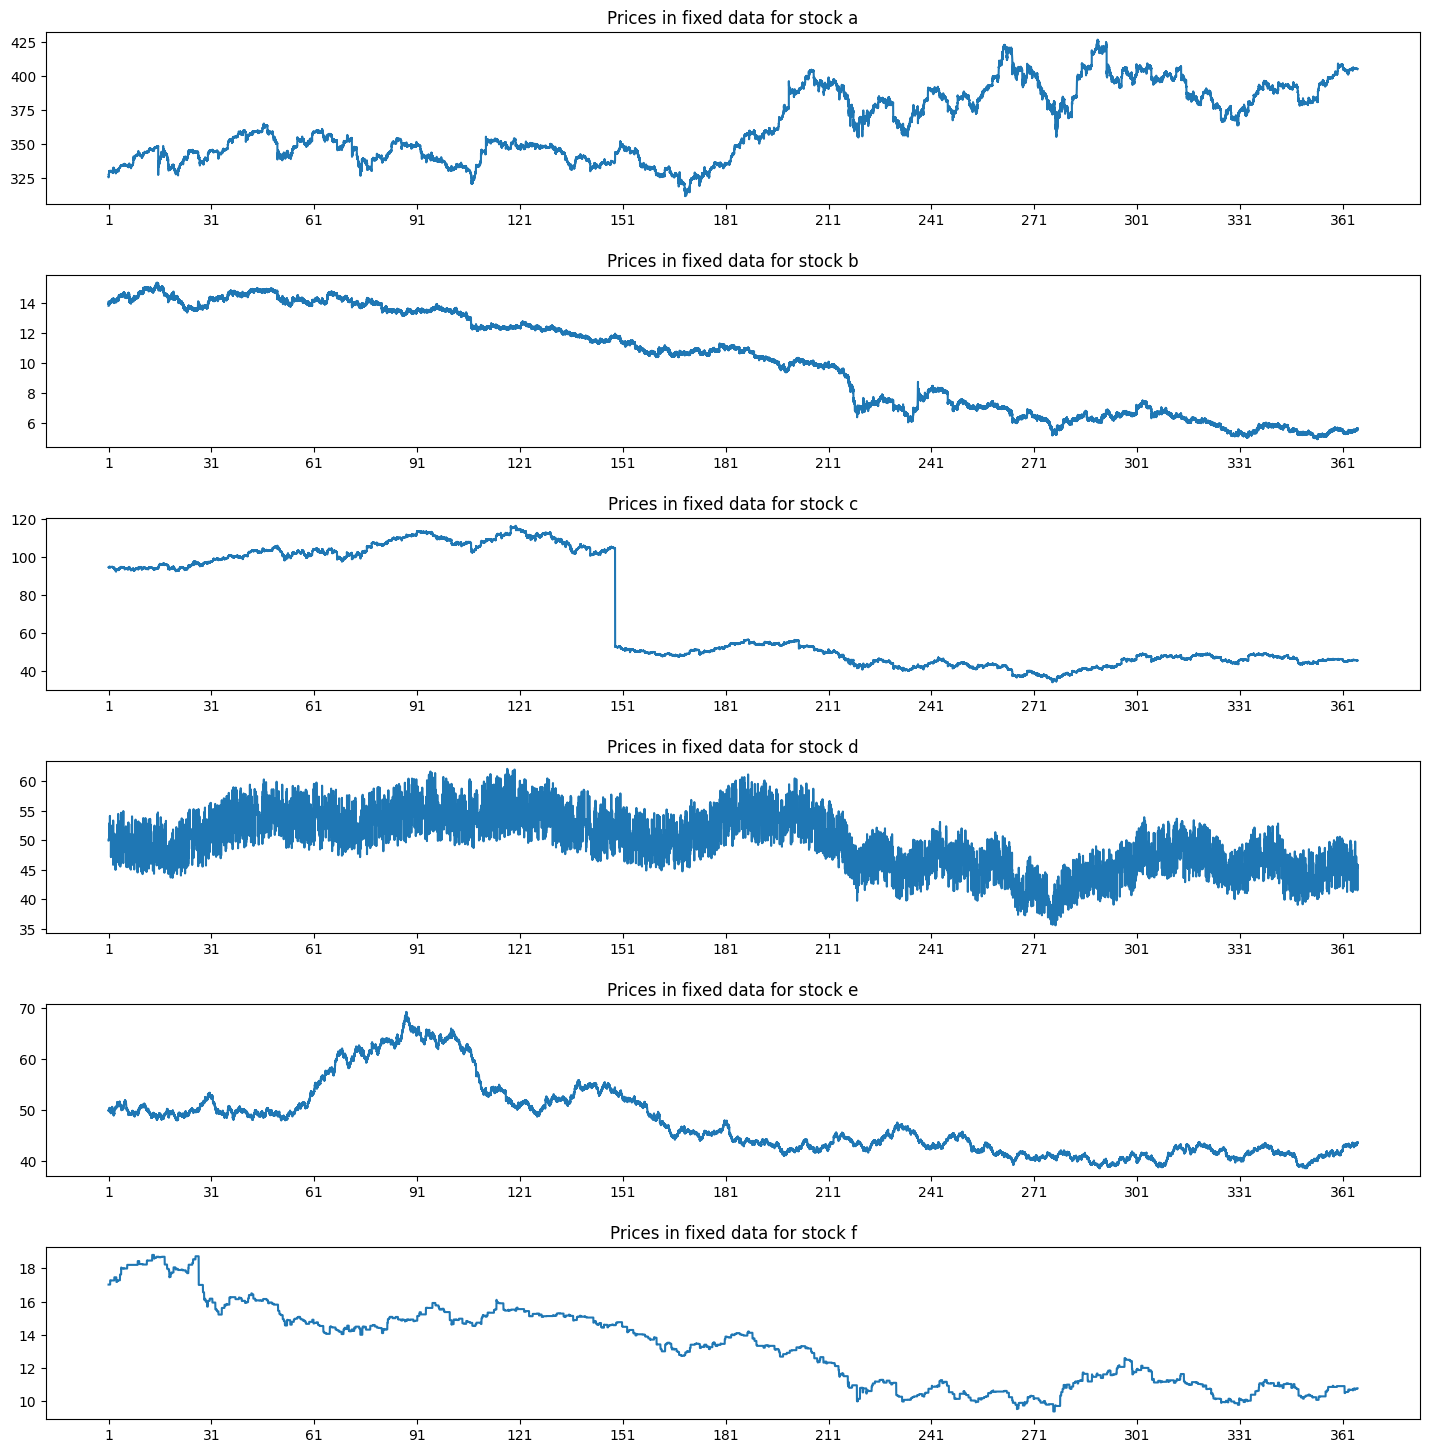

In [12]:
fig, axs = plt.subplots(6, figsize=(15,15))
fig.tight_layout(pad=3.0)

for i,j in enumerate('abcdef'):
    axs[i].plot(data.index, data[j])
    axs[i].set_title("Prices in fixed data for stock %s"%j)
    axs[i].set_xticks(range(0,98352,30*270))
    axs[i].set_xticklabels(range(1,366,30))

#### Remarks
- Some stocks seem to have more fluctuating prices everday (denser looking plots, especially stock `d`).
- We can plot some moving averages to notice any general time-dependent trends in these series. <br>
Select 5\*391 as window size (number of minutes in a week) for a weekly average price. 



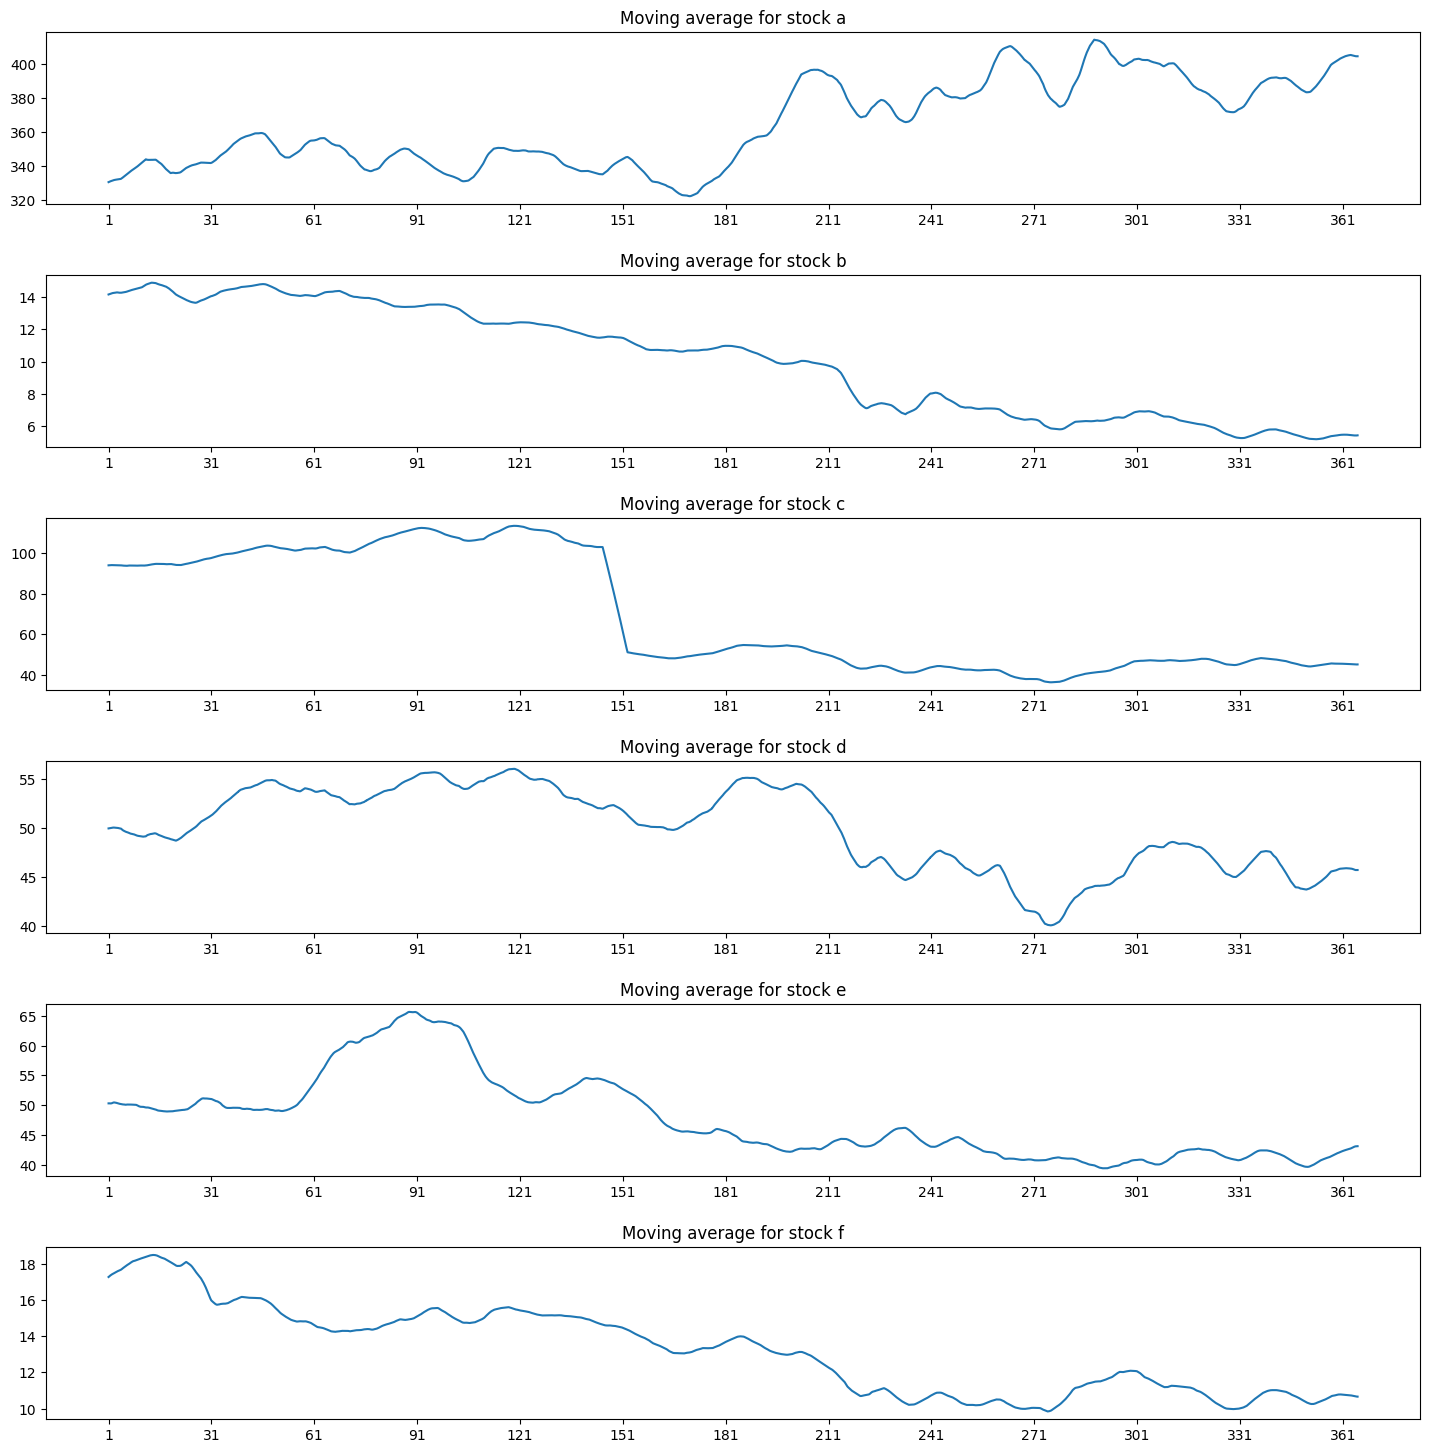

In [13]:
MA = {} #Dictionary for moving averages
for i in 'abcdef':
    MA[i] = data[i].rolling(window=5*391, center=True, min_periods=2*391).mean()

fig, axs = plt.subplots(6, figsize=(15,15))
fig.tight_layout(pad=3.0)

for i,j in enumerate('abcdef'):
    axs[i].plot(MA[j].index, MA[j])
    axs[i].set_title("Moving average for stock %s"%j)
    axs[i].set_xticks(range(0,98352,30*270))
    axs[i].set_xticklabels(range(1,366,30))

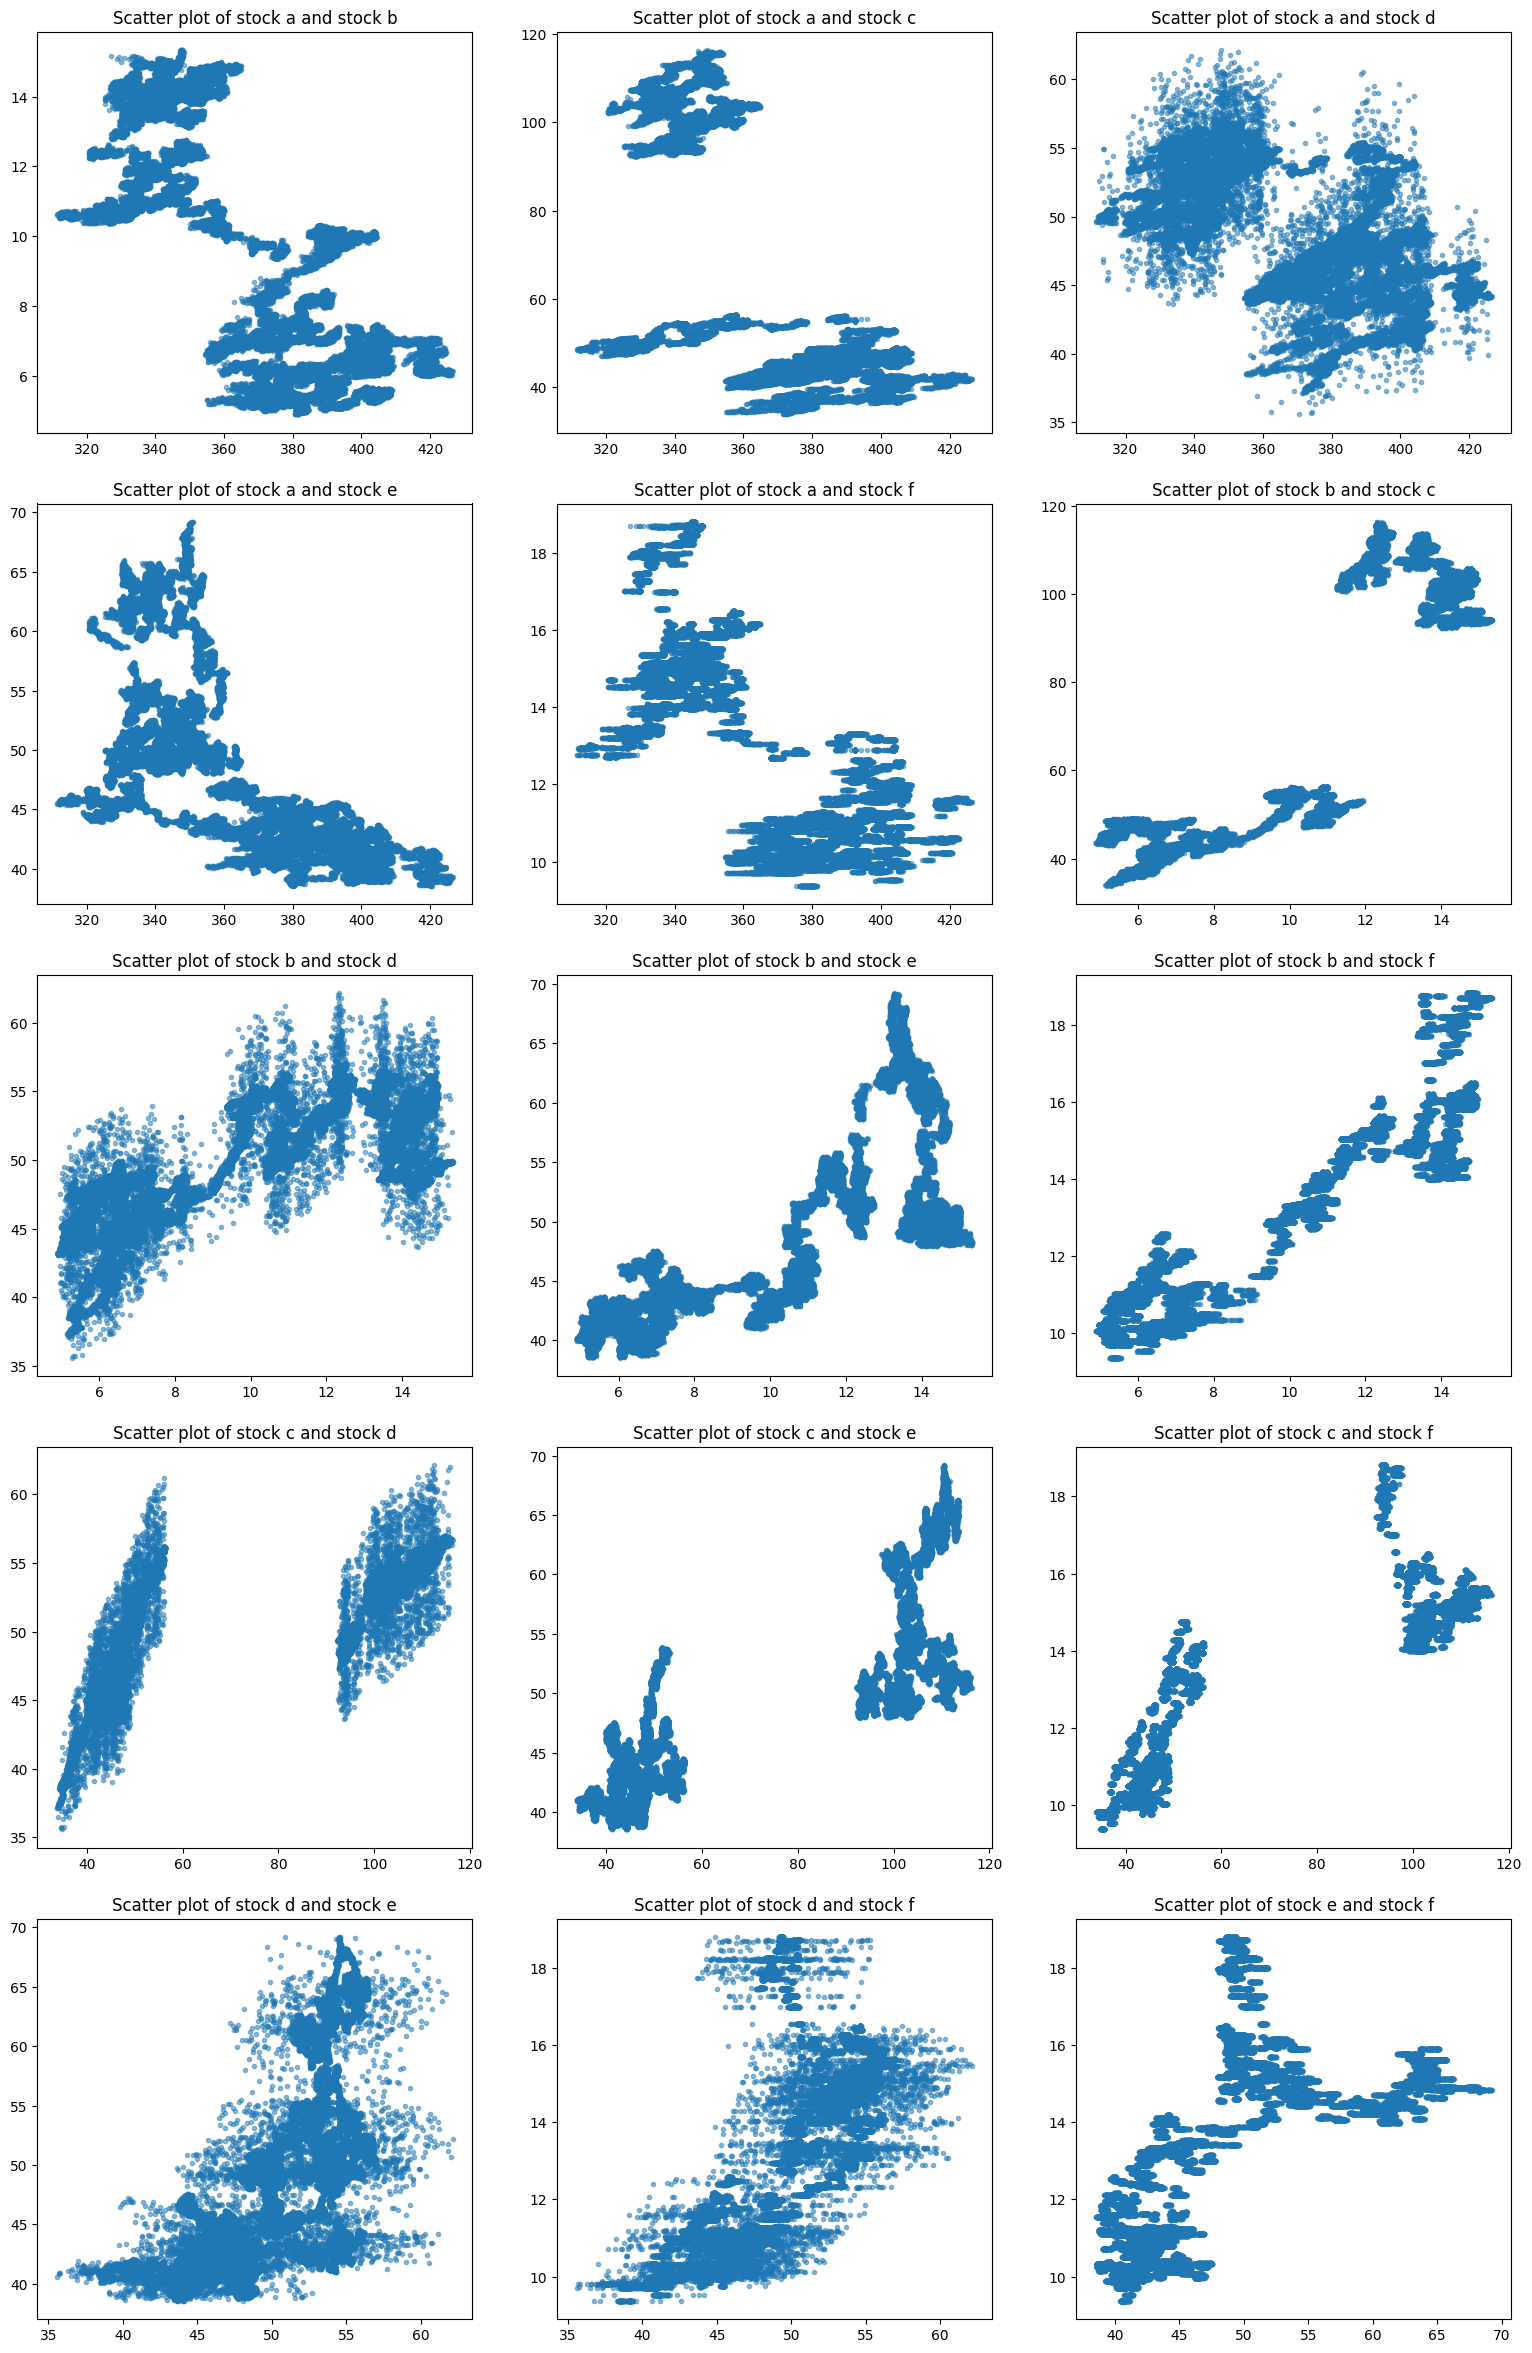

In [14]:
fig, axs = plt.subplots(5,3, figsize=(16,24))
fig.tight_layout(pad=3.0)

re_id = {(1,2):(0,0),(1,3):(0,1),(1,4):(0,2),(1,5):(1,0),(1,6):(1,1),(2,3):(1,2),(2,4):(2,0),(2,5):(2,1),(2,6):(2,2),(3,4):(3,0),(3,5):(3,1),(3,6):(3,2),(4,5):(4,0),(4,6):(4,1),(5,6):(4,2)}

for i,a in enumerate('abcdef',start=1):
    for j,b in enumerate('abcdef'[i:],start=i+1):
        (x,y) = re_id[(i,j)]
        axs[x,y].scatter(data[a], data[b],marker='.',alpha=0.5)
        axs[x,y].set_title("Scatter plot of stock %s and stock %s"%(a,b))

#### Remarks
- There do not seem to be any obvious polynomial trends exhibited by the prices of any stock, except maybe linearity in stock `b`. <br>
- Probably a good idea to calculate volatility are train on that directly, instead of predicting prices for the coming month and then calculating volatility. <br> 
- Errors would propogate a lot too, if using a DiRec strategy from a smaller horizon. 



### Modifications to data from referenced paper
The referenced paper says the use of high frequency data does not necessarily improve volatility prediction. <br>
So we group the data by days, in the hopes of extracting meaningful daily information for calculating returns in a sensible way. 


In [15]:
grouped_data = data.groupby('day')
ranges = grouped_data.max() - grouped_data.min()
ranges.describe()

,time,a,b,c,d,e,f
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,389.285714,6.662163,0.381964,1.581591,8.964230,1.412341,0.277183
std,11.338934,3.553288,0.161745,0.735120,1.049837,0.578278,0.203135
min,210.000000,1.425000,0.190000,0.352000,4.843000,0.480000,0.000000
25%,390.000000,4.128750,0.280000,1.056000,8.256250,1.020000,0.137500
50%,390.000000,5.855000,0.340000,1.372500,8.984500,1.255000,0.232500
75%,390.000000,8.478750,0.430000,1.944000,9.684750,1.662500,0.372500
max,390.000000,26.475000,1.315000,4.195000,11.800000,4.790000,1.730000


#### Remarks 
- The grouped daily prices do not seem to vary a lot, when compared with their means from `data.describe()` in the beginning for ratio. <br>
Possible exception of stock `d` with high `mean` for ranges, about 20% of its mean over full data. Expected that large deviation from price plot. <br>
- We may not lose too much information by aggregating data to one price per day. 3 obvious choices would be 
  - opening price
  - closing price
  - average price
  
Check availability of these data points. <br> 


In [16]:
a, b = day_list.copy(), day_list.copy()

for i in data.index:
    if data.loc[i,'time'] == 570:
        a.remove(data.loc[i,'day'])
    if data.loc[i,'time'] == 960:
        b.remove(data.loc[i,'day'])
        
a,b

([], [327])

In [17]:
data[data['day']==327]

,day,time,a,b,c,d,e,f
88757,327,570,368.350,5.215,43.610,44.020,40.33,9.865
88758,327,571,368.920,5.135,43.605,43.985,40.33,9.865
88759,327,572,369.640,5.145,43.678,44.030,40.34,9.865
88760,327,573,368.775,5.255,43.657,44.040,40.31,9.865
88761,327,574,369.380,5.265,43.718,44.070,40.25,9.865
...,...,...,...,...,...,...,...,...
88963,327,776,364.570,5.115,43.413,43.935,40.24,9.765
88964,327,777,364.700,5.115,43.405,43.875,40.24,9.765
88965,327,778,364.545,5.215,43.405,43.865,40.27,9.765
88966,327,779,364.380,5.125,43.325,43.855,40.33,9.765


- All days have the opening price. 
- Only one day (327) does not have closing price. <br> 
That day, data collection ends at `13:00:00` time, with row index 88967.


Create data points for opening and closing prices using this. 

In [18]:
price_opening = data.copy()[data['time']==570]
price_closing = data.copy()[data['time']==960]
price_average = grouped_data.mean()

#Add the one missing closing value using row index seen above
price_closing.loc[88967] = data.loc[88967]
price_closing.loc[88967, 'time'] = 960
price_closing = price_closing.sort_index()

#Set indices to day number moving forward
price_opening.set_index('day', inplace=True)
price_opening.index = price_opening.index.astype(int)
price_closing.set_index('day', inplace=True)
price_closing.index = price_closing.index.astype(int)

### Comparing different price metrics 

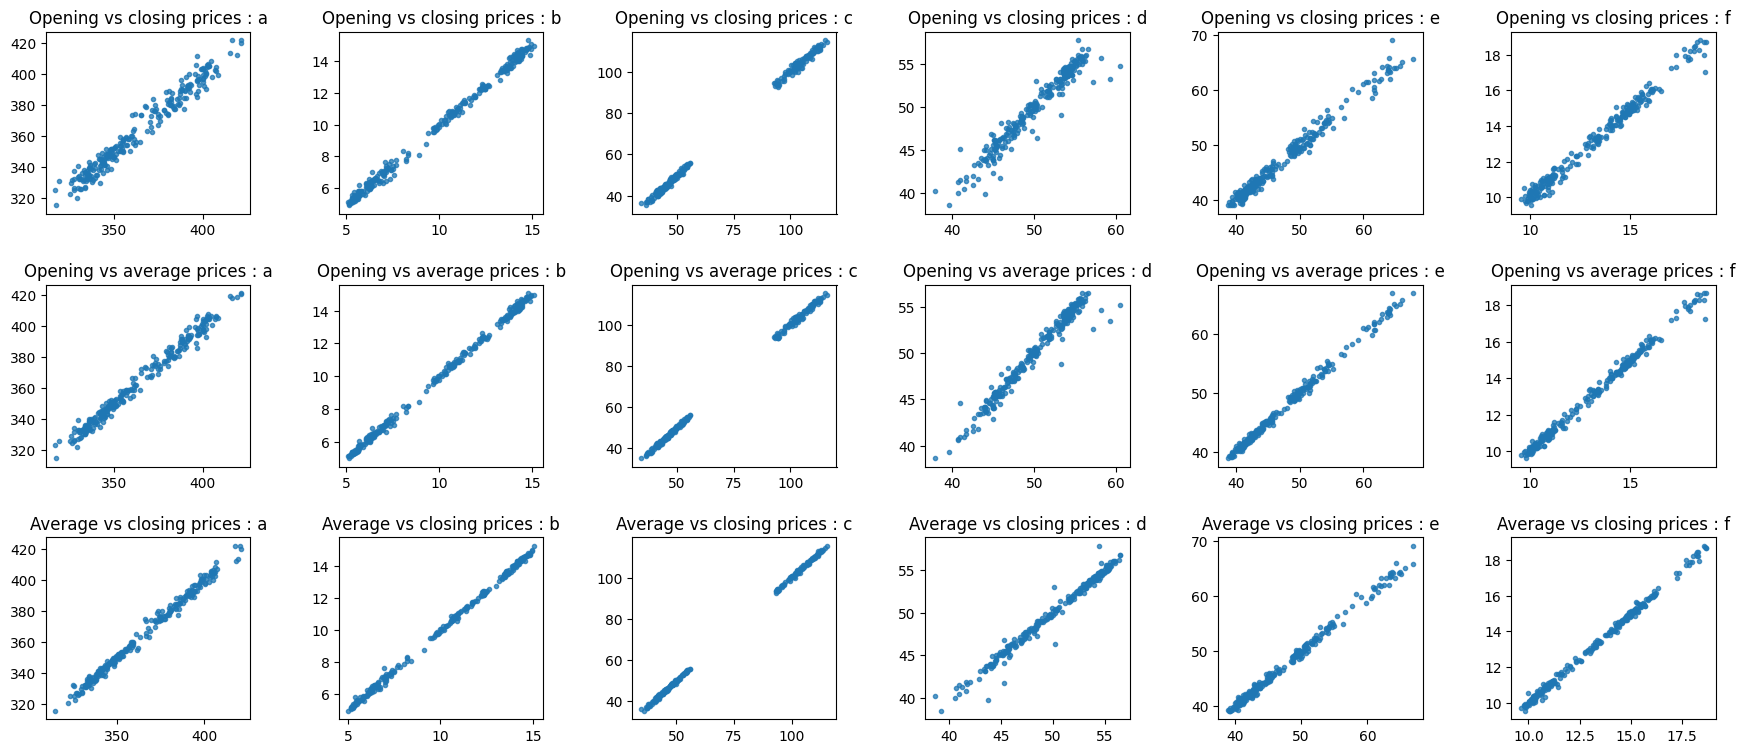

In [19]:
fig, axs = plt.subplots(3,6, figsize=(18,8))
fig.tight_layout(pad=3.0)

for i,j in enumerate('abcdef'):
    axs[0,i].scatter(price_opening[j], price_closing[j], marker='.', alpha=0.75)
    axs[0,i].set_title("Opening vs closing prices : %s"%j)
    axs[1,i].scatter(price_opening[j], price_average[j], marker='.', alpha=0.75)
    axs[1,i].set_title("Opening vs average prices : %s"%j)
    axs[2,i].scatter(price_average[j], price_closing[j], marker='.', alpha=0.75)
    axs[2,i].set_title("Average vs closing prices : %s"%j)

#### Remark
- All 3 types of prices aggregated per day seem very correlated.
- There should not be much benefit for choosing one over other, so we stick to "average price"

In [20]:
price = price_average

### Calculating returns from the prices selected from above
We look at 2 different types of returns, namely absolute and logarithmic. If final price is $V_1$ and initial price was $V_0$, then  <br>
- Holding period return = $\frac{V_1 - V_0}{V_0} = \frac{V_1}{V_0} - 1$ <br> <br>
- Logarithmic return = $\log\left(\frac{V_f}{V_i}\right)$

We consider the prices $V_0$ and $V_1$ over a horizon lag of **1 month**, since we need to predict the **monthly** volatility of returns. <br>
In our context, 1 month is around `21` days (which is `252/12)`. So `V_i` will be `V_f` lagged by 21 days.

In [21]:
#Setting a month number o fdays value = 21, to make process modular.
#Reference paper said month days = 20, so possibly better results with that?

M = 21

In [22]:
hop_returns = pd.DataFrame({i: (price[i].values[M:]/price[i].values[:-M])-1 for i in 'abcdef'})
log_returns = pd.DataFrame({i: np.log(price[i].values[M:]/price[i].values[:-M]) for i in 'abcdef'})

In [24]:
log_returns

,a,b,c,d,e,f
0,0.044796,0.011488,0.043658,0.031449,0.011934,-0.090337
1,0.037321,0.014058,0.054983,0.041124,-0.017871,-0.123539
2,0.036895,-0.015409,0.051121,0.044560,-0.032975,-0.117513
3,0.051721,0.013061,0.067769,0.064633,-0.013614,-0.113651
4,0.060312,0.029749,0.065608,0.078808,-0.003516,-0.116594
...,...,...,...,...,...,...
226,0.083191,0.071886,0.042388,0.034822,0.022767,0.088293
227,0.104673,0.053879,0.049965,0.046423,0.026950,0.101764
228,0.076808,-0.000370,-0.014620,0.010120,0.064292,0.061483
229,0.077130,0.050183,-0.008964,0.011783,0.042464,0.062927


In [25]:
# Number of remaining data points after letting go of one month
T = len(log_returns)

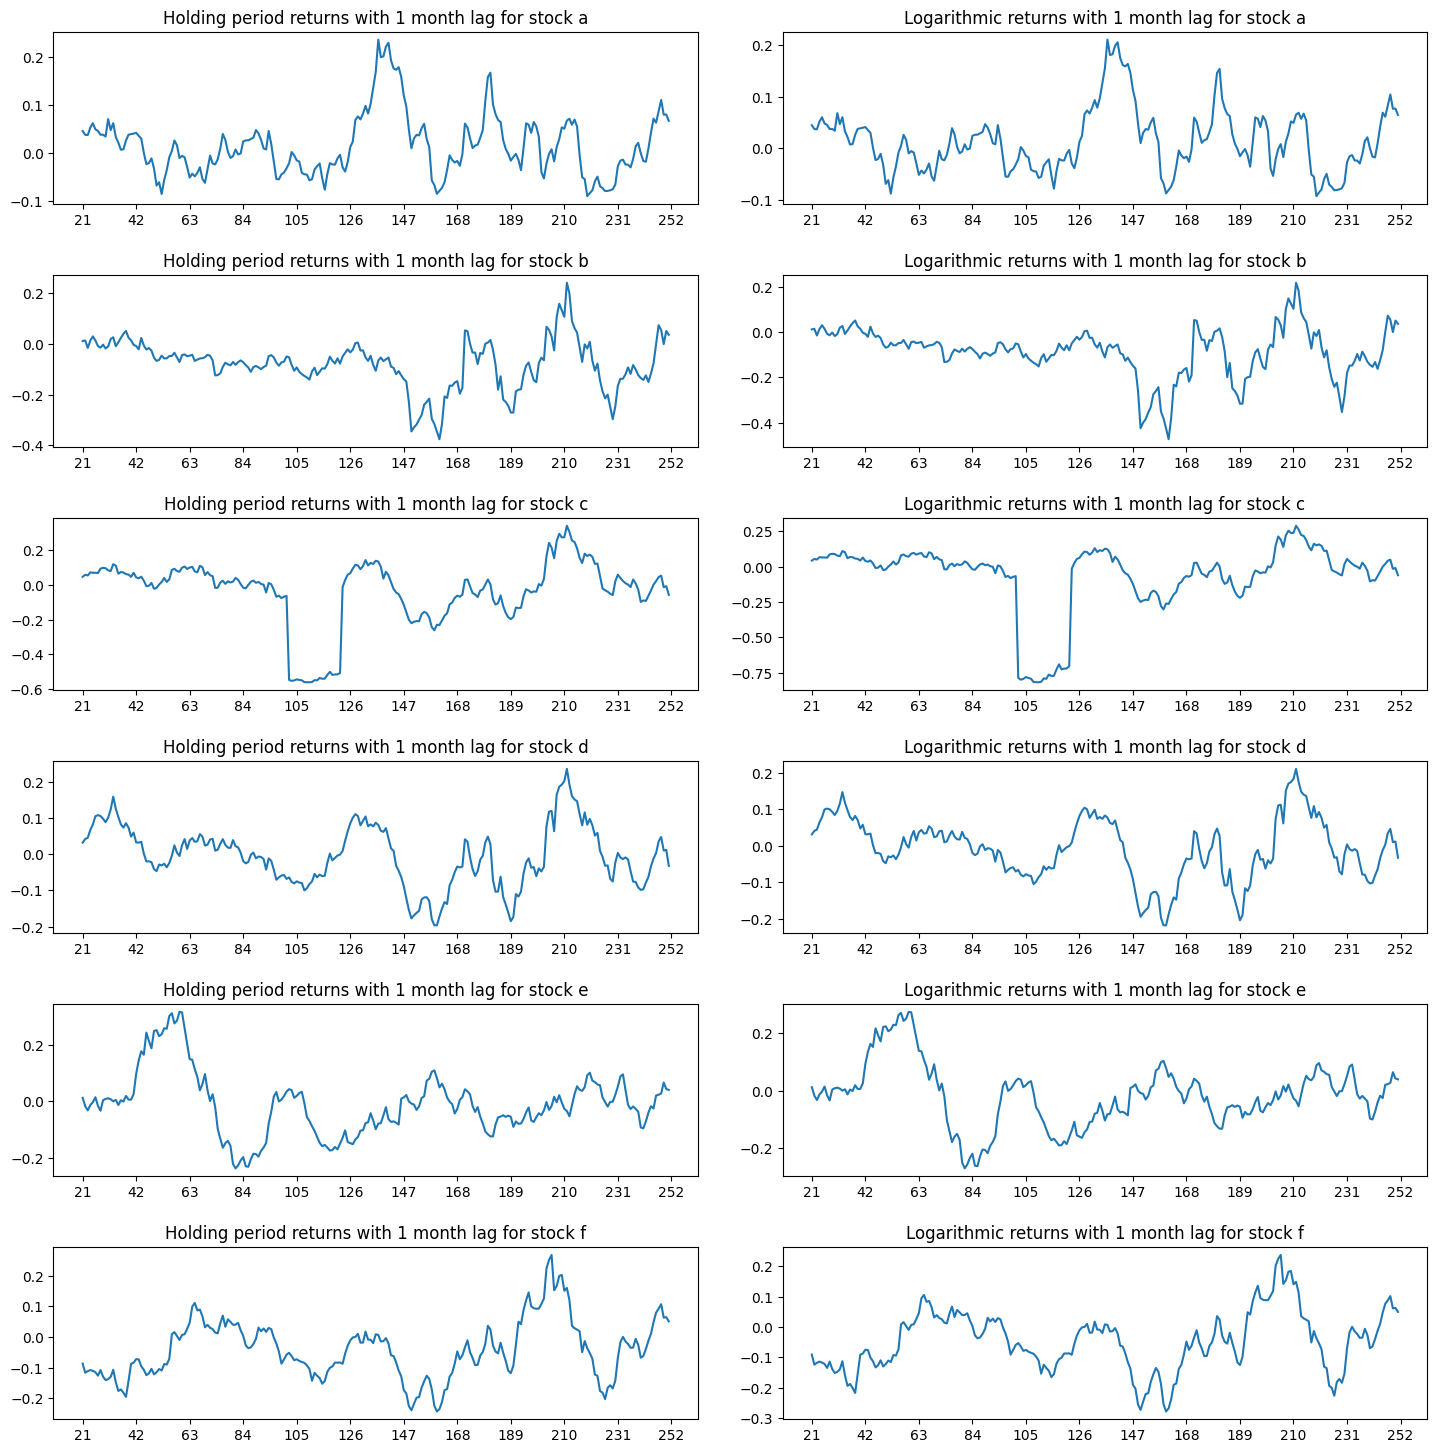

In [26]:
fig, axs = plt.subplots(6,2, figsize=(15,15))
fig.tight_layout(pad=3.0)

for i,j in enumerate('abcdef'):
    axs[i, 0].plot(hop_returns[j].index, hop_returns[j])
    axs[i, 0].set_title("Holding period returns with 1 month lag for stock %s"%j)
    axs[i, 1].plot(log_returns[j].index, log_returns[j])
    axs[i, 1].set_title("Logarithmic returns with 1 month lag for stock %s"%j)
    plt.sca(axs[i,0])
    plt.xticks(range(0,T+1,M), range(M,T+M+1,M))
    plt.sca(axs[i,1])
    plt.xticks(range(0,T+1,M), range(M,T+M+1,M))

- This makes sense because for small values of $x$, we indeed have $\log(1+x) \approx x$.

So now on, we can stick to just logarithmic returns for our consideration. <br>
To calculate past monthly volatility, we see the standard deviation of returns for 1 month in the past. 

In [27]:
volatility_month = pd.DataFrame({i: log_returns[i].rolling(M, min_periods=1).std() for i in 'abcdef'})

In [28]:
volatility_month

,a,b,c,d,e,f
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.005286,0.001817,0.008008,0.006841,0.021075,0.023477
2,0.004444,0.016321,0.005757,0.006799,0.022852,0.017688
3,0.007033,0.014178,0.010087,0.013947,0.018661,0.014530
4,0.009963,0.016294,0.010075,0.019197,0.016723,0.012807
...,...,...,...,...,...,...
226,0.046805,0.092350,0.048299,0.040314,0.050640,0.076843
227,0.049903,0.099924,0.050095,0.044787,0.051151,0.075987
228,0.049064,0.097170,0.049219,0.045453,0.053424,0.070941
229,0.047226,0.087632,0.047834,0.045483,0.054343,0.061887


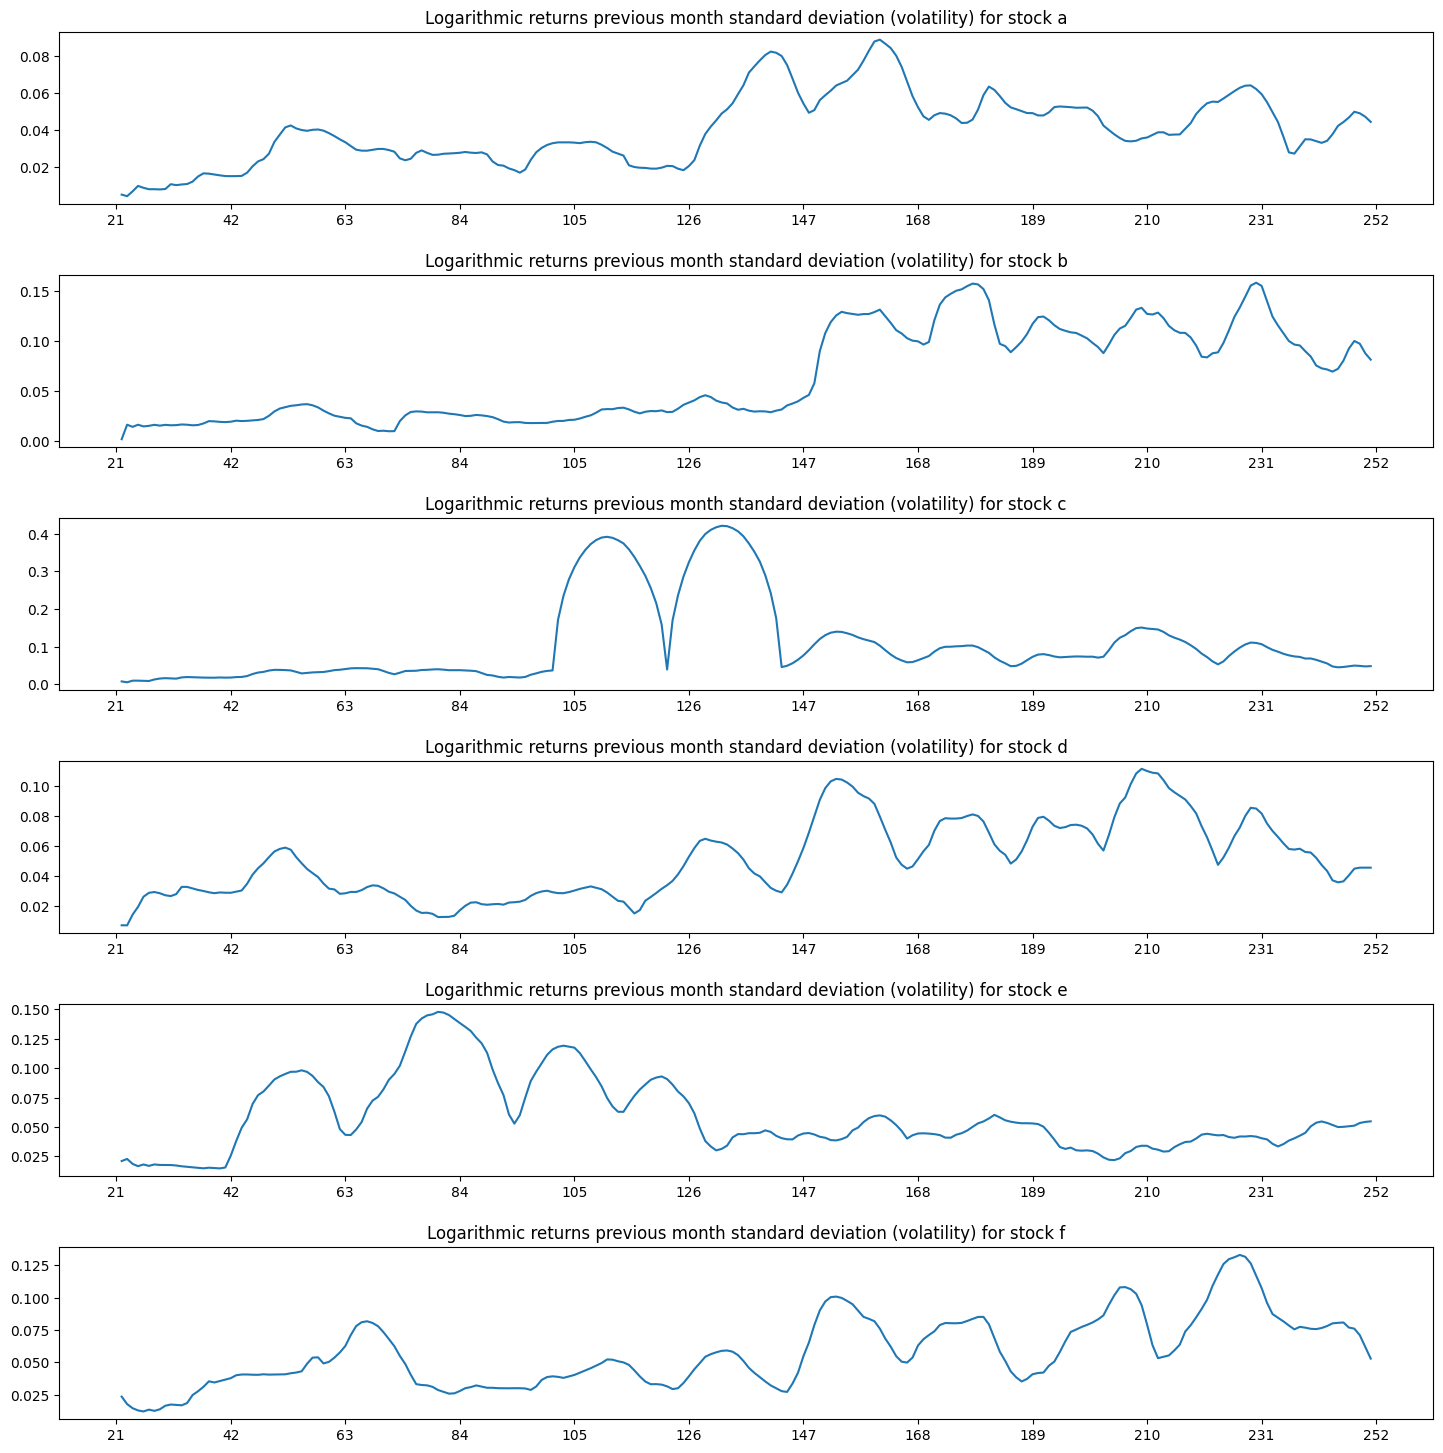

In [29]:
fig, axs = plt.subplots(6, figsize=(15,15))
fig.tight_layout(pad=3.0)

for i,j in enumerate('abcdef'):
    axs[i].plot(volatility_month[j].index, volatility_month[j])
    axs[i].set_title("Logarithmic returns previous month standard deviation (volatility) for stock %s"%j)
    plt.sca(axs[i])
    plt.xticks(range(0,T+1,M), range(M,T+M+1,M))

### Creating relevant features for estimating volatility
Referenced papers mention that past data more than 50 days old does not have much effect on predictions. <br>
Reasonable time frame to take into consideration for using past data would be around 2 months, set it to that.

Some possibly good predictors for future volatility, such as:
  1. Past squared returns
  2. Absolute returns
  3. Range of returns (max-min)
  4. Past volatility lag (standard deviation)
  5. Realized daily volatility
  6. Realized daily power (sum of intra-daily absolute returns)
  
For the purpose of our task, we will make use of the **first 4** of these possible features sampled over previous 2 months. <br>
Note that using the 5th and 6th features requires higher frequency data usage, so grouping by day will not work. 

#### Lead time, start time constraints
We needed 1st month's price data to calculate monthly returns, so 1 month is unusable. <br>
2nd month's return data is needed to to calculate first usable monthly volatility, so 2nd month is unavailable. <br>
Only past 2 months data is relevant according to referenced paper, third month is from where usable features data starts. <br>
Since we need to leave one month lead time, the training targets of volatility start from 5th month.

In [30]:
# Create a rolling range with M window for 3rd feature
log_returns_range_month = pd.DataFrame({i: log_returns[i].rolling(M).max()-log_returns[i].rolling(M).min() for i in 'abcdef'})

# Create the 4 features discussed above
X_psqre = np.square(np.array([log_returns[i].values[n-M:n] for n in range(3*M,T-M) for i in 'abcdef']))
X_absre = np.abs(np.array([log_returns[i].values[n-M:n] for n in range(3*M,T-M) for i in 'abcdef']))
X_range = np.array([log_returns_range_month[i].values[n-M:n] for n in range(3*M,T-M) for i in 'abcdef'])
X_pastv = np.array([volatility_month[i].values[n-M:n] for n in range(3*M,T-M) for i in 'abcdef'])

#Create the target vector (volatility) falttened the same way
y = np.array([volatility_month[i].values[n] for n in range(4*M,T) for i in 'abcdef'])

#### Remarks
- All the X data is flattened, each feature is combined vector for all 6 stocks with shape `(6*7*21, 2*21)` . <br>
- It might be interesting to separate each stock and view independently. Code an efficient way to separate the data if needed.
- Also need an efficient way to combine the features if we wanna use a combination of them. 

In [31]:
#Create a way to separate the stocks per feature/vector.
indicator = np.array([i for _ in range(3*M,T-M) for i in 'abcdef'])
def separate_stock(X, i): 
    """Return slice of X corresponding to stock i
    Also works on Y, the target vector (first column of indicator is same)"""
    return X[indicator==i]

#Create a way to combine multiple features for training with an option to separate stocks as well
def get_XY(s, i=None):
    """Input s : string like '1234' or '13', showing which features are to be combined
    Input i : None by default but stock 'a', 'b' etc if needed separately"""
    L = [X_psqre, X_absre, X_range, X_pastv]
    if i: L = [separate_stock(X, i) for X in L]
    D = dict(zip('1234', L))
    Y = separate_stock(y,i) if i else y
    return np.concatenate([D[j] for j in s], axis=1), Y

### Training models and testing with cross validation

#### First try fitting on the entire data at once
To capture possible dependence on other stock returns. <br>
As suggested in referenced paper, we will use mean squared error for validation. <br>
Using 10-fold cross validation in this method.

In [32]:
Data_presets = ['1','2','3','4', '12', '13', '14', '23', '24', '34', '123', '124', '134', '234', '1234']

In [33]:
Errors_full = {i:0 for i in Data_presets}

for s in Data_presets:
    X, Y = get_XY(s)
    scores = -1 * cross_val_score(LinearRegression(), X, Y, cv=20, scoring='neg_mean_squared_error')
    Errors_full[s] = avg_mse = np.mean(scores)
    print('For preset %s : Error = %f'%(s.rjust(4),avg_mse))

For preset    1 : Error = 0.002895
For preset    2 : Error = 0.003179
For preset    3 : Error = 0.003416
For preset    4 : Error = 0.003363
For preset   12 : Error = 0.003143
For preset   13 : Error = 0.003102
For preset   14 : Error = 0.002634
For preset   23 : Error = 0.003143
For preset   24 : Error = 0.002888
For preset   34 : Error = 0.004235
For preset  123 : Error = 0.003377
For preset  124 : Error = 0.002728
For preset  134 : Error = 0.003031
For preset  234 : Error = 0.003393
For preset 1234 : Error = 0.003511


In [34]:
best_pre = min(Errors_full, key=Errors_full.get)
best_err = Errors_full[best_pre]
print("Best combination of features is %s\nError at preset = %f"%(best_pre, best_err))

Best combination of features is 14
Error at preset = 0.002634


#### Remarks
- Validation score data suggests that a combination of features 1 and 4 works best for the prediction when all stocks data is used.

#### Try fitting on separate stocks, one at a time
Now we try for separate stocks the same strategy of iterating over presets to save the best, see if error gets smaller. 

In [35]:
Errors_pre = {p:0 for p in Data_presets}
Errors_sep = {i:Errors_pre.copy() for i in 'abcdef'}

for s in Data_presets:
    for i in 'abcdef':
        X, Y = get_XY(s, i=i)
        score_i = -1 * cross_val_score(LinearRegression(), X, Y, cv=20, scoring='neg_mean_squared_error')
        Errors_sep[i][s] = np.mean(score_i)
    avg_mse = np.mean([Errors_sep[i][s] for i in 'abcdef'])
    print('For preset %s : Error = %f'%(s.rjust(4),avg_mse))

For preset    1 : Error = 0.002747
For preset    2 : Error = 0.003112
For preset    3 : Error = 0.002930
For preset    4 : Error = 0.002666
For preset   12 : Error = 0.002883
For preset   13 : Error = 0.006154
For preset   14 : Error = 0.007255
For preset   23 : Error = 0.004781
For preset   24 : Error = 0.004703
For preset   34 : Error = 0.001849
For preset  123 : Error = 0.006925
For preset  124 : Error = 0.005857
For preset  134 : Error = 0.006677
For preset  234 : Error = 0.004088
For preset 1234 : Error = 0.026338


In [36]:
best_presets = {i:'' for i in 'abcdef'}
li = []
for i in 'abcdef':
    best_err = min(Errors_sep[i].values())
    best_pre = [j for j in Data_presets if Errors_sep[i][j]==best_err][0]
    li.append(best_err)
    best_presets[i] = best_pre
    print("Best combination for %s is %s\nError at preset = %f\n"%(i,best_pre, best_err))
    

Best combination for a is 1
Error at preset = 0.000260

Best combination for b is 4
Error at preset = 0.001421

Best combination for c is 34
Error at preset = 0.005972

Best combination for d is 2
Error at preset = 0.000580

Best combination for e is 24
Error at preset = 0.000256

Best combination for f is 3
Error at preset = 0.000684



In [37]:
np.mean(li)

0.001528700059283936

#### Remarks
- Average MSE here for the special feature selections seems to be lower than full data MSE errors. 
- So we will train models according to best preset for each stock individually, for final predictions.

In [38]:
trainings = {i:(LinearRegression(), get_XY(best_presets[i],i=i)) for i in 'abcdef'}

for i,(model,(X,Y)) in trainings.items():
    model.fit(X,Y)

In [39]:
X_test_psqre = np.square(np.array([log_returns[i].values[n-M:n] for n in range(T-M,T) for i in 'abcdef']))
X_test_absre = np.abs(np.array([log_returns[i].values[n-M:n] for n in range(T-M,T) for i in 'abcdef']))
X_test_range = np.array([log_returns_range_month[i].values[n-M:n] for n in range(T-M,T) for i in 'abcdef'])
X_test_pastv = np.array([volatility_month[i].values[n-M:n] for n in range(T-M,T) for i in 'abcdef'])

test_indicator = np.array([i for _ in range(T-M,T) for i in 'abcdef'])

def separate_test_stock(X, i): 
    """Return slice of X corresponding to stock i"""
    return X[test_indicator==i]

def get_test_X(s, i=None):
    """Input s : string like '1234' or '13', showing which features are to be combined
    Input i : None by default but stock 'a', 'b' etc if needed separately"""
    L = [X_test_psqre, X_test_absre, X_test_range, X_test_pastv]
    if i: L = [separate_test_stock(X, i) for X in L]
    D = dict(zip('1234', L))
    return np.concatenate([D[j] for j in s], axis=1)

In [40]:
y_forecast = {i:trainings[i][0].predict(get_test_X(best_presets[i],i=i)) for i in 'abcdef'}

In [47]:
Results = pd.DataFrame()
Results.index = list('abcdef')

for i in 'abcdef':
    Results.loc[i,'Next Month End Volatility'] = y_forecast[i][-1]
    Results.loc[i,'Next Month Avg Volatility'] = y_forecast[i].mean()

Results['MSE Error'] = (np.array(li))

Results['Annualized Monthly Volatility'] = (np.sqrt(12)*Results['Next Month Avg Volatility']).apply("{:.02%}".format)
Results['Fulctuation from RMSE'] = (np.sqrt(12*Results['MSE Error'])).apply("{:.02%}".format)

Results

,Next Month End Volatility,Next Month Avg Volatility,MSE Error,Annualized Monthly Volatility,Fulctuation from RMSE
a,0.050440,0.046208,0.000260,16.01%,5.58%
b,0.066497,0.095632,0.001421,33.13%,13.06%
c,0.178262,0.109423,0.005972,37.91%,26.77%
d,0.041586,0.059324,0.000580,20.55%,8.34%
e,0.050644,0.043909,0.000256,15.21%,5.54%
f,0.069823,0.077180,0.000684,26.74%,9.06%


### Conclusion 
The fluctuation values seem quite large, a different choice of loss function for validation could help. <br> 
A different combination of choices made along the way could also improve this result.

### Appendix : explainability of model used

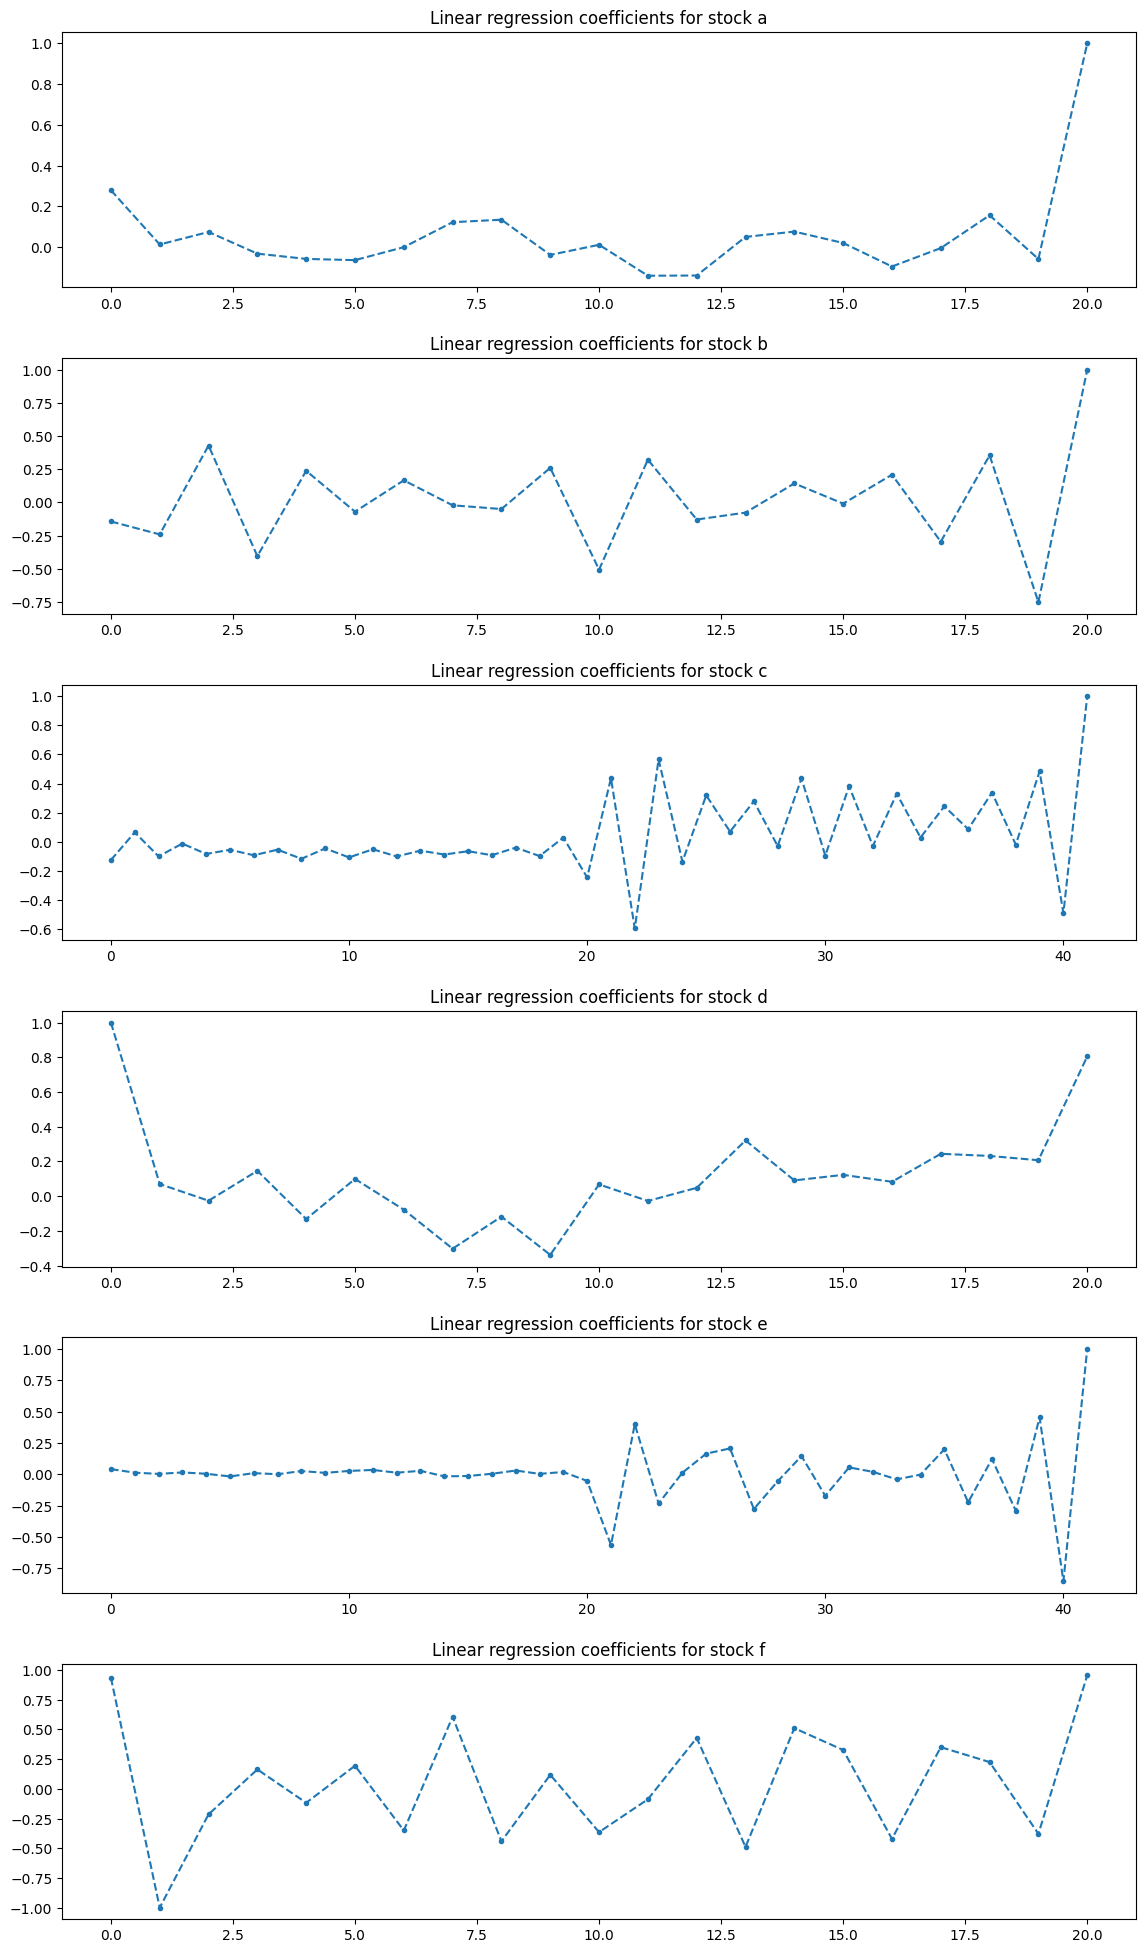

In [64]:
fig, axs = plt.subplots(6, figsize=(12,20))
fig.tight_layout(pad=3.0)

for j,i in enumerate('abcdef'):
    V = trainings[i][0].coef_
    V /= np.max(np.abs(V))
    axs[j].plot(V, '.--')
    axs[j].set_title('Linear regression coefficients for stock %s'%i)